Tissue extractor and qpatiff_converter


This script takes a 3D tiff or qptiff fluorescent image containing multiple tissues, crops each tissue out of the larger image, and saves a tiff subimage for each tissue. It expects images of dimension (cycles, Ypixels, Xpixels). The script is based on image segmentation principles and code presented on the scikit-image site at this link (https://scikit-image.org/docs/dev/user_guide/tutorial_segmentation.html). 

The steps of the script are:

1. The image is downsized by downscale_factor in each dimension. 
2. A Gaussian filter with std. dev. equal to sigma is applied to the image to remove outliers.
3. Watershed segmentation is applied to segment the image into individual tissues.
4. (Optional) User can manually clean up tissue piece region assignments
5. A bounding box is generated around each region.
6. Each bounding box is used to crop the original full tiff stack.
7. The resulting cropped tiff stack of each region is saved as its own tiff.

Parameters:

path - (string) the path to the tiff or qptiff image (including image name and extension)

downscale_factor - (int) the factor to downsize the original nuclear image by in the Y and X dimensions (default = 16)

sigma - (float) the standard deviation of the Gaussian filter (default = 5.0)

DNAslice - (int) the slice to extract from the original tiff stack to perform the tissue segmentation (default = 0)

padding - (int) the amount of padding in pixels to put around bounding box used to crop each tissue out of full image (deafult = 50)

savepath - (string) the path to save output cropped images


# Set up environment

In [1]:
#import standard packages
import os
import pandas as pd
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
import skimage

import warnings
warnings.filterwarnings('ignore')

code_dir = '/Users/yuqitan/Nolan Lab Dropbox/Yuqi Tan/analysis_pipeline/demo_data/pipeline_test_112023/src' # current where the code is stored, this will be replaced by pip install soon
data_dir = '/Users/yuqitan/Nolan Lab Dropbox/Yuqi Tan/analysis_pipeline/demo_data/' # where the data is stored
output_dir = '/Users/yuqitan/Nolan Lab Dropbox/Yuqi Tan/analysis_pipeline/demo_data/brain/CTRL04/' # where data output is stored
file = 'S1121_Scan1.qptiff' 
file_path = output_dir + file 

if not os.path.exists(output_dir): # check if output path exist - if not generate the path
    os.makedirs(output_dir)

sys.path.append(code_dir) # This code is only needed if you want to load functions from a non-default directory

from qptiff_converter import * # Functions for cell segmentation

# 0.1 Downscale CODEX images

In [2]:
#how much to downscale your image for easy segmentation computation
downscale_factor = 64
padding = 50

First, specify parameters and load image. A histogram of marker expression levels should appear. Select a lower_cutoff value very close to background and an upper_cutoff value in the range of positive expression and input these values into the lower_cutoff and upper_cutoff parameters in the following cell.

Reading in the qptiff file, might take awhile!
Loaded nuclear image of dimension (Y,X) = (28800, 23040)


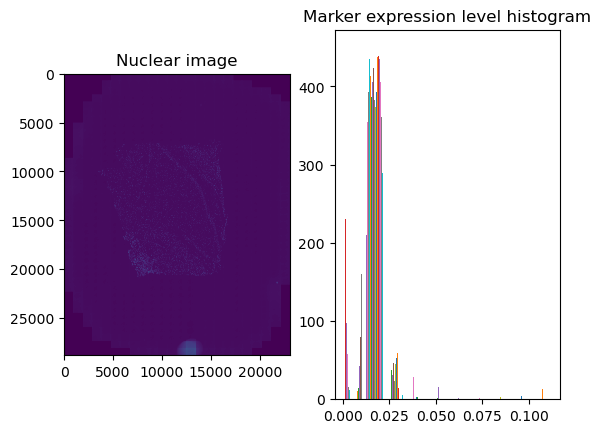

returning scaled down image!


In [3]:
resized_im = hf_downscale_tissue(file_path = file_path)

# 0.2 Segment individual tissue pieces

Identified 1 tissue pieces


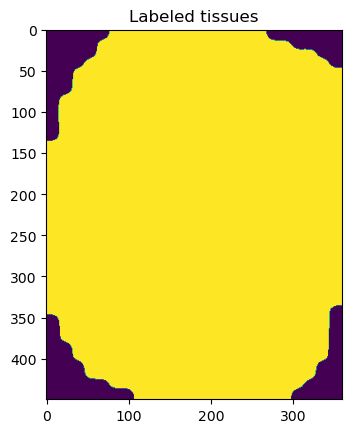

Saving the labels from the segmentation!


In [4]:
tissueframe = tl_label_tissue(resized_im,
                lower_cutoff = 0.012,
                upper_cutoff = 0.02
                             )

In [5]:
tissueframe.head()

,tissue,y,x,region1
0,1,0,77,1
1,1,0,78,1
2,1,0,79,1
3,1,0,80,1
4,1,0,81,1


# 0.3 Rename tissue number (optional)

Optional: manually clean up automatic tissue region assignments. A tissue region often consists of multiple pieces of tissue that are not connected. Occasionally, the above algorithm will assign a piece of tissue to the incorrect region. The next two cells allow the user to manually correct such region mislabelings. 

Running the first cell generates two plots. The first plot shows the tissue piece labels. The second plot shows the final region assignments for the tissue pieces. These two plots can be used to identify the ID of the tissue piece you want to reassign and the region ID you want to assign it to. 

The second cell takes two parameters:

tissue_id - (int) this is the tissue ID of the piece of tissue you want to reassign

new_region_id - (int) this is the ID of the new region you want to assign this tissue piece to

Running the second cell relabels the region assignment of the specified tissue piece.

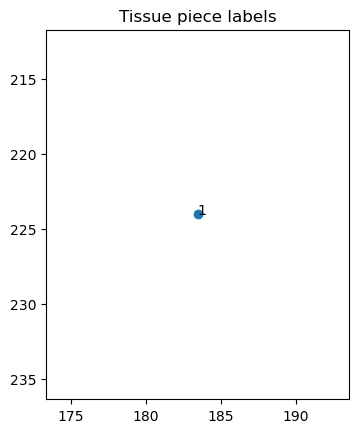

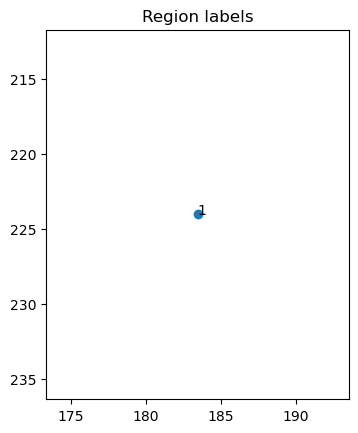

In [6]:
pl_tissue_lables(tissueframe=tissueframe, region = 'region1')

In [7]:
#Rename the regions based on annotations
rename_dict = {1:1}

for k in rename_dict.keys():
    tissueframe['region1'][tissueframe['tissue'] == k] = rename_dict[k]
    
#rename so ordered 1 through 8
tiss_num = {list(tissueframe['region1'].unique())[i]:i+1 for i in range(len(tissueframe['region1'].unique()))}
tissueframe['region']= tissueframe['region1'].map(tiss_num).copy()
tiss_num

{1: 1}

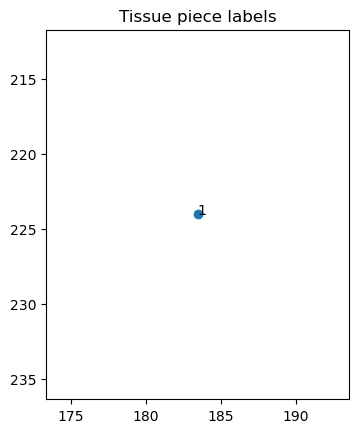

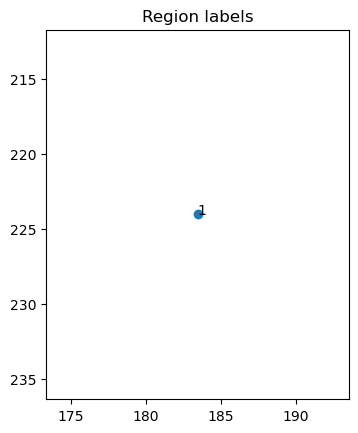

In [8]:
pl_tissue_lables(tissueframe=tissueframe, region = 'region')

In [9]:
tissueframe['region'].value_counts()

region
1    147128
Name: count, dtype: int64

# 0.4 Extract labeled tissues into subimages into indiviudal tiffstack

Reading in the qptiff file, might take awhile!


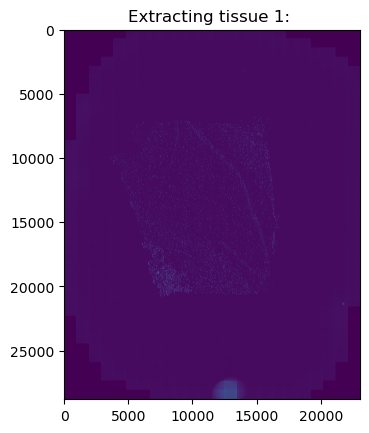

Saving tissue image at ./reg001_X01_Y01_Z01.tif


In [11]:
tl_save_labelled_tissue(filepath=file_path, 
                        tissueframe=tissueframe,
                        output_dir = output_dir
                       )